In [1]:
import pandas as pd
#pd.set_option("display.max_colwidth", 200)
#import swifter
import numpy as np
import re
import spacy
import time
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Create the March Modified Review Dataset

Read the March Review Dataset and extract the last review date for each listing. Merge the last review date with the May Review Dataset. From the merged dataset, only keep those reviews that are in English AND written before the last review date.

In [43]:
Reviews_Mar = pd.read_csv('Combined_Reviews_March.csv.gz', compression='gzip', error_bad_lines=False,\
                    parse_dates=['review_created_at'], dtype={'listing_id':str}, usecols=['listing_id','review_created_at'])

In [44]:
Reviews_Mar.head()
Reviews_Mar['listing_id'].nunique() 

257909

In [45]:
Mar_Summary = Reviews_Mar.groupby('listing_id').agg(last_rev_mar=('review_created_at', 'max'),
                                          rev_count_mar=('review_created_at', 'count')).reset_index()

In [46]:
print(Mar_Summary.shape)
Mar_Summary.info()

(257909, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257909 entries, 0 to 257908
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   listing_id     257909 non-null  object             
 1   last_rev_mar   257909 non-null  datetime64[ns, UTC]
 2   rev_count_mar  257909 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 5.9+ MB


In [40]:
May_Reviews = pd.read_csv('Combined_Reviews_May20.csv.gz', compression='gzip', error_bad_lines=False,\
                          parse_dates=['review_created_at'],
                          dtype={'reviewee_id':str,'review_id': str,'reviewer_id':str,'listing_id':str})

In [41]:
May_Reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10720558 entries, 0 to 10720557
Data columns (total 18 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   listing_id             object             
 1   reviews_count          int64              
 2   reviewee_deleted       bool               
 3   reviewee_first_name    object             
 4   reviewee_host_name     object             
 5   reviewee_id            object             
 6   reviewee_is_superhost  bool               
 7   review_id              object             
 8   review_created_at      datetime64[ns, UTC]
 9   review_language        object             
 10  review_rating          float64            
 11  review_comments        object             
 12  host_response          object             
 13  reviewer_deleted       bool               
 14  reviewer_first_name    object             
 15  reviewer_host_name     object             
 16  reviewer_id     

In [47]:
merged_rev = pd.merge(left = Mar_Summary, right = May_Reviews, left_on='listing_id', right_on='listing_id',how = 'inner')

In [49]:
merged_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10713549 entries, 0 to 10713548
Data columns (total 20 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   listing_id             object             
 1   last_rev_mar           datetime64[ns, UTC]
 2   rev_count_mar          int64              
 3   reviews_count          int64              
 4   reviewee_deleted       bool               
 5   reviewee_first_name    object             
 6   reviewee_host_name     object             
 7   reviewee_id            object             
 8   reviewee_is_superhost  bool               
 9   review_id              object             
 10  review_created_at      datetime64[ns, UTC]
 11  review_language        object             
 12  review_rating          float64            
 13  review_comments        object             
 14  host_response          object             
 15  reviewer_deleted       bool               
 16  reviewer_first_n

In [65]:
Final_Mar = merged_rev[ (merged_rev['review_created_at'] <= merged_rev['last_rev_mar']) &\
                        (merged_rev['review_language'].isin(['en'])) ]

In [67]:
print(Final_Mar.shape)
Final_Mar.head()

(10039121, 20)


listing_id              last_rev_mar  rev_count_mar  reviews_count  \
3   10000216 2020-02-03 18:52:50+00:00             48             51   
4   10000216 2020-02-03 18:52:50+00:00             48             51   
5   10000216 2020-02-03 18:52:50+00:00             48             51   
6   10000216 2020-02-03 18:52:50+00:00             48             51   
7   10000216 2020-02-03 18:52:50+00:00             48             51   

   reviewee_deleted reviewee_first_name reviewee_host_name reviewee_id  \
3             False                 Ana                Ana  49633363.0   
4             False                 Ana                Ana  49633363.0   
5             False                 Ana                Ana  49633363.0   
6             False                 Ana                Ana  49633363.0   
7             False                 Ana                Ana  49633363.0   

   reviewee_is_superhost    review_id         review_created_at  \
3                  False  546448378.0 2019-10-13 19:41:06+00:00   
4                  False  452620497.0 2019-05-13 18:38:48+00:00   
5                  False  449843473.0 2019-05-07 20:18:23+00:00   
6                  False  445522423.0 2019-04-29 17:12:35+00:00   
7                  False  434753673.0 2019-04-08 17:33:56+00:00   

  review_language  review_rating  \
3              en            5.0   
4              en            5.0   
5              en            5.0   
6              en            5.0   
7              en            5.0   

                                     review_comments host_response  \
3  Best part of the experience was the area. Stay...           NaN   
4  Definitely a great space. My group had a nice ...           NaN   
5  Clean living spaces and a spacious living area...           NaN   
6  This place was quiet and comfortable for my fa...           NaN   
7  My friends and I had a great time at Anaâs p...           NaN   

   reviewer_deleted reviewer_first_name reviewer_host_name reviewer_id  \
3             False              Isamar             Isamar  16878378.0   
4             False              Cedric             Cedric  51839245.0   
5             False               Larry              Larry  62574510.0   
6             False           Christine          Christine  43188726.0   
7             False                John               John  12297144.0   

   reviewer_is_superhost  
3                  False  
4                  False  
5                  False  
6                  False  
7                  False

In [68]:
Final_Mar = Final_Mar.reset_index(drop=True)

In [70]:
print(Final_Mar.shape)
print(Final_Mar['listing_id'].nunique())
Final_Mar.head()

(10039121, 20)
230751


listing_id              last_rev_mar  rev_count_mar  reviews_count  \
0   10000216 2020-02-03 18:52:50+00:00             48             51   
1   10000216 2020-02-03 18:52:50+00:00             48             51   
2   10000216 2020-02-03 18:52:50+00:00             48             51   
3   10000216 2020-02-03 18:52:50+00:00             48             51   
4   10000216 2020-02-03 18:52:50+00:00             48             51   

   reviewee_deleted reviewee_first_name reviewee_host_name reviewee_id  \
0             False                 Ana                Ana  49633363.0   
1             False                 Ana                Ana  49633363.0   
2             False                 Ana                Ana  49633363.0   
3             False                 Ana                Ana  49633363.0   
4             False                 Ana                Ana  49633363.0   

   reviewee_is_superhost    review_id         review_created_at  \
0                  False  546448378.0 2019-10-13 19:41:06+00:00   
1                  False  452620497.0 2019-05-13 18:38:48+00:00   
2                  False  449843473.0 2019-05-07 20:18:23+00:00   
3                  False  445522423.0 2019-04-29 17:12:35+00:00   
4                  False  434753673.0 2019-04-08 17:33:56+00:00   

  review_language  review_rating  \
0              en            5.0   
1              en            5.0   
2              en            5.0   
3              en            5.0   
4              en            5.0   

                                     review_comments host_response  \
0  Best part of the experience was the area. Stay...           NaN   
1  Definitely a great space. My group had a nice ...           NaN   
2  Clean living spaces and a spacious living area...           NaN   
3  This place was quiet and comfortable for my fa...           NaN   
4  My friends and I had a great time at Anaâs p...           NaN   

   reviewer_deleted reviewer_first_name reviewer_host_name reviewer_id  \
0             False              Isamar             Isamar  16878378.0   
1             False              Cedric             Cedric  51839245.0   
2             False               Larry              Larry  62574510.0   
3             False           Christine          Christine  43188726.0   
4             False                John               John  12297144.0   

   reviewer_is_superhost  
0                  False  
1                  False  
2                  False  
3                  False  
4                  False

In [71]:
Final_Mar.to_csv ('Combined_Reviews_March_Modified.csv.gz', index = None, header=True, compression='gzip')

# Read the March Modified Dataset and Preprocess

In [6]:
Reviews = pd.read_csv('Combined_Reviews_March_Modified.csv.gz', compression='gzip', error_bad_lines=False,\
                     dtype={'listing_id':str, 'review_comments':str}, usecols=['listing_id','review_comments'])

In [9]:
print(Reviews['listing_id'].nunique())
print(Reviews.shape)

230751
(10039121, 2)


In [10]:
# Remove NaN comments and remove empty ones
Reviews = Reviews[ (Reviews['review_comments'].notnull()) & (Reviews['review_comments'] != '') ]
print(Reviews.shape)
print(Reviews['listing_id'].nunique())

(10037098, 2)
230742


In [46]:
Reviews.head()
#print(Reviews.at[4,'review_comments'])

listing_id                                    review_comments
0   10000216  Best part of the experience was the area. Stay...
1   10000216  Definitely a great space. My group had a nice ...
2   10000216  Clean living spaces and a spacious living area...
3   10000216  This place was quiet and comfortable for my fa...
4   10000216  My friends and I had a great time at Anaâs p...

In [53]:
# Remove tags (<><\>), punctuation, multiple whitespaces, numbers, stopwords, words <= 2 chars

from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation,strip_multiple_whitespaces,\
                                         strip_numeric,remove_stopwords,strip_short
from gensim.utils import deaccent
remove_non_ascii = lambda x: ''.join([character if ord(character) < 128 else '' for character in x])

def pre_process_comments(comment):
    processed_str = gensim.parsing.preprocessing.preprocess_string(comment, filters=[deaccent, \
                                strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric,\
                                remove_non_ascii, lambda x: x.lower(), remove_stopwords, strip_short])
    return processed_str

Reviews['review_comments'] = Reviews['review_comments'].apply(pre_process_comments)


In [54]:
Reviews.head()

listing_id                                    review_comments
0   10000216  [best, experience, area, staying, little, hava...
1   10000216  [definitely, great, space, group, nice, time, ...
2   10000216  [clean, living, spaces, spacious, living, area...
3   10000216  [place, quiet, comfortable, family, lot, space...
4   10000216  [friends, great, time, anaas, place, house, sp...

In [56]:
# Build the bigram and trigram models

all_words = Reviews['review_comments'].tolist()

bigram = gensim.models.Phrases(all_words, min_count=10, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_words], threshold=10)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Save Bigram and Trigram
bigram_mod.save('Bigram_March20_Modified')
trigram_mod.save('Trigram_March20_Modified')

In [62]:
# Implement bigram and trigram to all rows

# Load Bigram and Trigram

#bigram_mod = gensim.models.phrases.Phraser.load('Bigram_March20_Modified')
#trigram_mod = gensim.models.phrases.Phraser.load('Trigram_March20_Modified')

# Print Bigrams and Trigrams

#for bigram in bigram_mod.phrasegrams.keys():
    #print(bigram)

#for trigram in trigram_mod.phrasegrams.keys():
#    print(trigram)   

def make_bi_tri_grams(comment):
    
    all_bigrams = bigram_mod[comment]
    all_trigrams = trigram_mod[bigram_mod[all_bigrams]]
    return all_trigrams
    
Reviews['review_comments'] = Reviews['review_comments'].apply(make_bi_tri_grams)

In [64]:
# Save Pre-processed Dataset
Reviews.to_pickle('Reviews_Mar20_Modified_PreLem.pkl.gz',compression='gzip')

In [65]:
# Remove NaN comments and remove empty ones
Reviews = Reviews[ Reviews['review_comments'].str.len() > 0 ]
print(Reviews.shape)
print(Reviews['listing_id'].nunique())

(10025200, 2)
230705


# Aggregate Reviews for Each Listing and Lemmatize

In [74]:
# Combine all the reviews for each listing_id

Reviews_grouped = Reviews.groupby('listing_id').agg(sum).reset_index()

print(Reviews_grouped.shape)
Reviews_grouped.head()

(230705, 2)


listing_id                                    review_comments
0   10000216  [best, experience, area, staying, little_havan...
1   10000222  [great, place, great, people, totally, recomme...
2   10000255  [wonderful, air_bnb, host, home, great, commun...
3   10000435  [lives_hype, excellent, ann, easy, work, airbn...
4   10000726  [philas, place, great, landing, spot, explored...

In [85]:
# Read list of words, join, lemmatize (lemmatize will split the joined string), return list of words

nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 1030000 

def lemmatization(comments):
    
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    word_joined = ' '.join([word for word in comments])

    doc = nlp(word_joined)
    output = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return output

Reviews_grouped['review_comments'] = Reviews_grouped['review_comments'].apply(lemmatization)

In [86]:
print(Reviews_grouped.shape)
Reviews_grouped.head()

(230705, 2)


listing_id                                    review_comments
0   10000216  [good, experience, area, stay, blast, culture,...
1   10000222  [great, place, great, people, totally, recomme...
2   10000255  [wonderful, host, home, great, communication, ...
3   10000435  [great, pool, great, close, convenient, shoppi...
4   10000726  [phila, place, great, landing, spot, explore, ...

In [2]:
# Save Lemmatized Dataset
Reviews_grouped.to_pickle('Reviews_Mar20_Modified_Lemmatized.pkl.gz', compression='gzip')

NameError: name 'Reviews_grouped' is not defined

# Create a Corpus, Filter with a TF-IDF Cut-off, Run LDA

In [96]:
# Create a list of list
processed_reviews = Reviews_grouped['review_comments'].tolist()

# Create Dictionary
id2word = corpora.Dictionary(processed_reviews)
print('Total Vocabulary Size:', len(id2word))

# Create Corpus : Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_reviews]

# Create Tf-Idf Model
tfidf = gensim.models.TfidfModel(corpus, id2word = id2word)

Total Vocabulary Size: 314664


In [97]:
#filter words with low tf-idf

cut_off = 0.05

for i in range(0, len(corpus)):
    
    bow = corpus[i]
    bow_ids = [id for id, value in bow]
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < cut_off]
    
    #new_bow = [b for b in bow if b[0] not in low_value_words]
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] 

    #reassign        
    corpus[i] = new_bow

In [101]:
# LDA with 15 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle
import time


num_of_topics = 15

start_time = time.time()

lda_model_15 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001)

pickle.dump(lda_model_15,open('lda_mar_modern_model_15_0_05',"wb"))

coherence_model_lda_model_15 = CoherenceModel(model=lda_model_15, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda15 = coherence_model_lda_model_15.get_coherence()
print('Coherence Score: ', coherence_lda15)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_15, corpus, id2word)

end_time = time.time()
print('Time Taken: ',end_time-start_time)

vis

Coherence Score:  0.3414757732800307
Time Taken:  25220.016406536102


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.085200 -0.043116       1        1  17.060726
7     -0.278485  0.129195       2        1  11.030767
1     -0.188717  0.227945       3        1  10.809893
4     -0.273779 -0.065748       4        1   7.594807
11     0.235945  0.023105       5        1   6.821093
14    -0.111035  0.250216       6        1   6.695990
0     -0.143991 -0.285516       7        1   6.406219
12     0.189623  0.205671       8        1   5.526920
8      0.001699  0.010746       9        1   5.280567
6     -0.036631 -0.239078      10        1   4.737306
13    -0.097196 -0.078486      11        1   4.214598
3      0.116430  0.076386      12        1   3.932879
5      0.164193  0.030168      13        1   3.602568
9      0.077101 -0.215502      14        1   3.181397
10     0.259645 -0.025987      15        1   3.104265, topic_info=           Term          Freq         Total Category  logprob  loglift
217       great  1.582405e+06  1.582405e+06  Default  30.0000  30.0000
26    apartment  1.079199e+06  1.079199e+06  Default  29.0000  29.0000
348       place  2.078631e+06  2.078631e+06  Default  28.0000  28.0000
451        stay  2.080654e+06  2.080654e+06  Default  27.0000  27.0000
409        room  8.749390e+05  8.749390e+05  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
699       suite  5.915727e+03  3.826176e+04  Topic15  -5.3860   1.6056
588       hotel  6.374973e+03  5.397045e+04  Topic15  -5.3112   1.3363
1835      ocean  4.870750e+03  1.911285e+04  Topic15  -5.5804   2.1053
650      window  4.758188e+03  1.953439e+04  Topic15  -5.6038   2.0601
609    peaceful  4.848473e+03  3.779673e+04  Topic15  -5.5850   1.4188

[1162 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1          1  0.111390  absolutely
1          3  0.121071  absolutely
1          5  0.000053  absolutely
1          8  0.073921  absolutely
1         12  0.582676  absolutely
...      ...       ...         ...
3543       1  1.000125      youare
62144      8  1.000415        yumi
91454     10  1.000117         yve
16945     12  0.999797      yvonne
31854     10  0.999988        zach

[2999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 2, 5, 12, 15, 1, 13, 9, 7, 14, 4, 6, 10, 11])

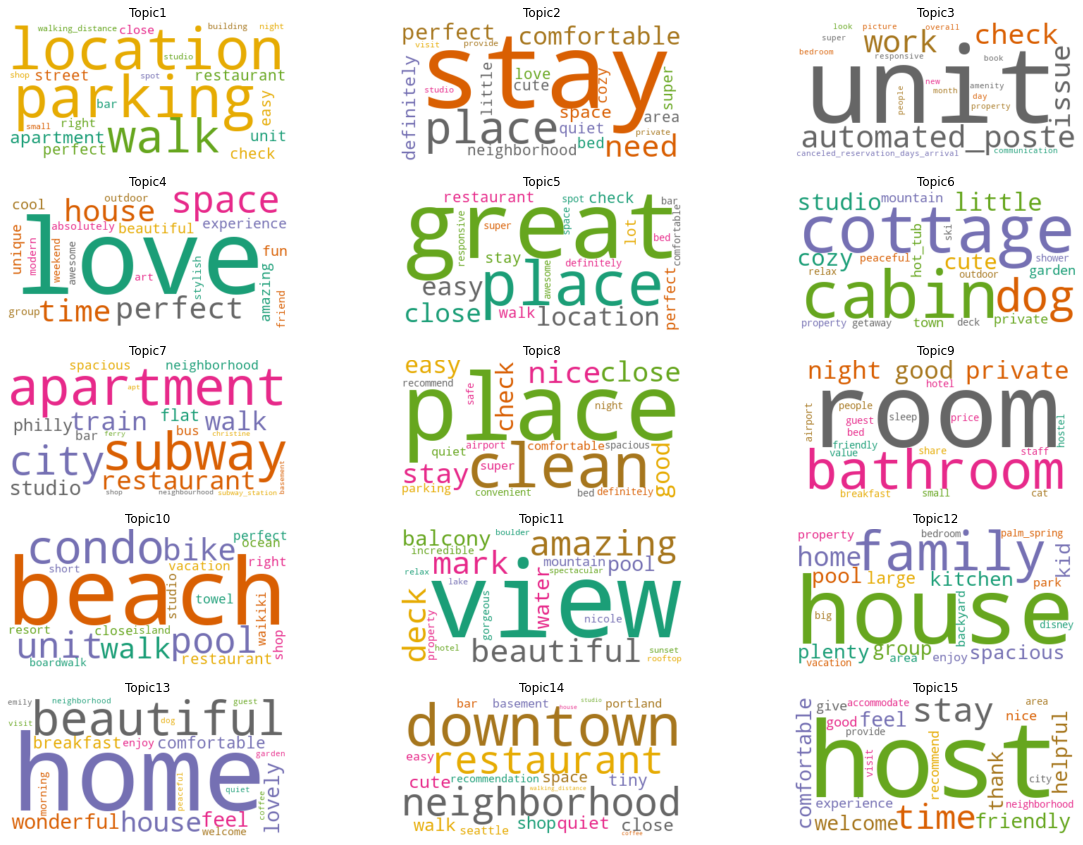

In [106]:
# Create Word Cloud of the topics 

from wordcloud import WordCloud

topics = [ [ (term, round(wt, 3)) for term, wt in lda_model_15.show_topic(n, topn=20) ] for n in range(0, lda_model_15.num_topics) ]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], \
                         columns = ['Term'+str(i) for i in range(1, 21)], \
                         index=['Topic '+str(t) for t in range(1, lda_model_15.num_topics+1)])

#pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms_in_Topic'], index=['Topic'+str(t) for t in range(1, lda_model_15.num_topics+1)] )
topics_df

topics_df.head()


# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(15):

    wc.generate(text=topics_df['Terms_in_Topic'][i])
    
    plt.subplot(5, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [2]:
# Retrieve Pre-processed Dataset
Reviews_grouped = pd.read_pickle('Reviews_Mar20_Modified_Lemmatized.pkl.gz', compression='gzip')

# Create a list of list
processed_reviews = Reviews_grouped['review_comments'].tolist()

# Create Dictionary
id2word = corpora.Dictionary(processed_reviews)
print('Total Vocabulary Size:', len(id2word))

# Create Corpus : Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_reviews]

# Create Tf-Idf Model
tfidf = gensim.models.TfidfModel(corpus, id2word = id2word)


#filter words with low tf-idf

cut_off = 0.05

for i in range(0, len(corpus)):
    
    bow = corpus[i]
    bow_ids = [id for id, value in bow]
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < cut_off]
    
    #new_bow = [b for b in bow if b[0] not in low_value_words]
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] 

    #reassign        
    corpus[i] = new_bow

Total Vocabulary Size: 314664


In [34]:
# LDA with 8, 12, 16, 20, 24 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle
import time

Num_Topics, Coherence_Score = [],[]


start_time = time.time()


for k in range(8, 28, 4):

    num_of_topics = k

    model_name = 'lda_model_' + str(num_of_topics)

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001)

    pickle.dump(lda_model,open(model_name,"wb"))

    
    coherence_model = CoherenceModel(model = lda_model, texts = processed_reviews, dictionary = id2word, coherence = 'c_v')
    coherence_lda = coherence_model.get_coherence()
    
    print('Number of topic: ', num_of_topics,' Coherence Score: ', coherence_lda)
    
    #print('pickle.dump(lda_model,open(',model_name,',"wb"))')
    #coherence_lda = num_of_topics/10
    
    Num_Topics.append(num_of_topics)
    Coherence_Score.append(coherence_lda)
    
    
end_time = time.time()
print('Time Taken: ',end_time-start_time)

all_coherences = np.column_stack((Num_Topics,Coherence_Score))
np.save('K_vs_Coherence.npy',all_coherences)

Number of topic:  8  Coherence Score:  0.32002995613165397
Number of topic:  12  Coherence Score:  0.3324896003859316
Number of topic:  16  Coherence Score:  0.3334033544046307
Number of topic:  20  Coherence Score:  0.3349382049230824
Number of topic:  24  Coherence Score:  0.3451778669791721
Time Taken:  32120.337745904922


[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]]


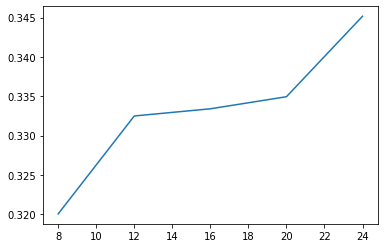

In [35]:
calculated_coherences = np.load('K_vs_Coherence.npy')
print(calculated_coherences)

plt.plot(calculated_coherences[:,0],calculated_coherences[:,1])

In [37]:
# Topic visualization for 24 topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.136870  0.018249       1        1  15.139445
1     -0.314807 -0.071768       2        1   8.071793
7     -0.299953  0.115076       3        1   6.870481
16    -0.224111 -0.154816       4        1   5.917078
4     -0.087178  0.170898       5        1   5.243266
11     0.180702 -0.062876       6        1   4.644957
18     0.021206 -0.181727       7        1   4.570963
0     -0.159202  0.120559       8        1   4.429598
19     0.076403  0.211850       9        1   3.831205
3     -0.062758  0.055157      10        1   3.777305
6      0.079166  0.062968      11        1   3.725072
20     0.028304 -0.069070      12        1   3.683220
22     0.042231  0.112253      13        1   3.518328
12    -0.003163 -0.270624      14        1   3.395247
13    -0.169128  0.008724      15        1   3.182378
5      0.052175 -0.189574      16        1   2.769237
14    -0.101364  0.085301      17        1   2.742723
9      0.164311  0.045575      18        1   2.646352
15    -0.035272 -0.088423      19        1   2.470911
21     0.094932  0.227227      20        1   2.286636
10     0.147767 -0.161065      21        1   2.278207
17     0.108019 -0.194255      22        1   1.776994
8      0.215561  0.115878      23        1   1.638794
23     0.109288  0.094484      24        1   1.389804, topic_info=           Term          Freq         Total Category  logprob  loglift
348       place  2.107416e+06  2.107416e+06  Default  30.0000  30.0000
217       great  1.581743e+06  1.581743e+06  Default  29.0000  29.0000
26    apartment  1.075131e+06  1.075131e+06  Default  28.0000  28.0000
451        stay  2.074904e+06  2.074904e+06  Default  27.0000  27.0000
282    location  1.045033e+06  1.045033e+06  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
849    entrance  3.230250e+03  9.608767e+03  Topic24  -5.1872   3.1859
3343     resort  3.735364e+03  2.569422e+04  Topic24  -5.0419   2.3476
2975  community  3.302588e+03  1.613876e+04  Topic24  -5.1650   2.6895
134         day  3.534565e+03  6.090384e+04  Topic24  -5.0971   1.4293
156       drive  2.603924e+03  2.391538e+04  Topic24  -5.4027   2.0585

[1706 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
163058      7  1.001838  abagail
52145       6  1.000603      abi
52670       7  1.002609  abigail
0           1  0.520752     able
0           2  0.016542     able
...       ...       ...      ...
103052      3  1.003729   yulexy
148622      8  1.001124     yuri
91454      11  0.999585      yve
16945      10  0.999695   yvonne
31854      24  0.999857     zach

[4594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 8, 17, 5, 12, 19, 1, 20, 4, 7, 21, 23, 13, 14, 6, 15, 10, 16, 22, 11, 18, 9, 24])

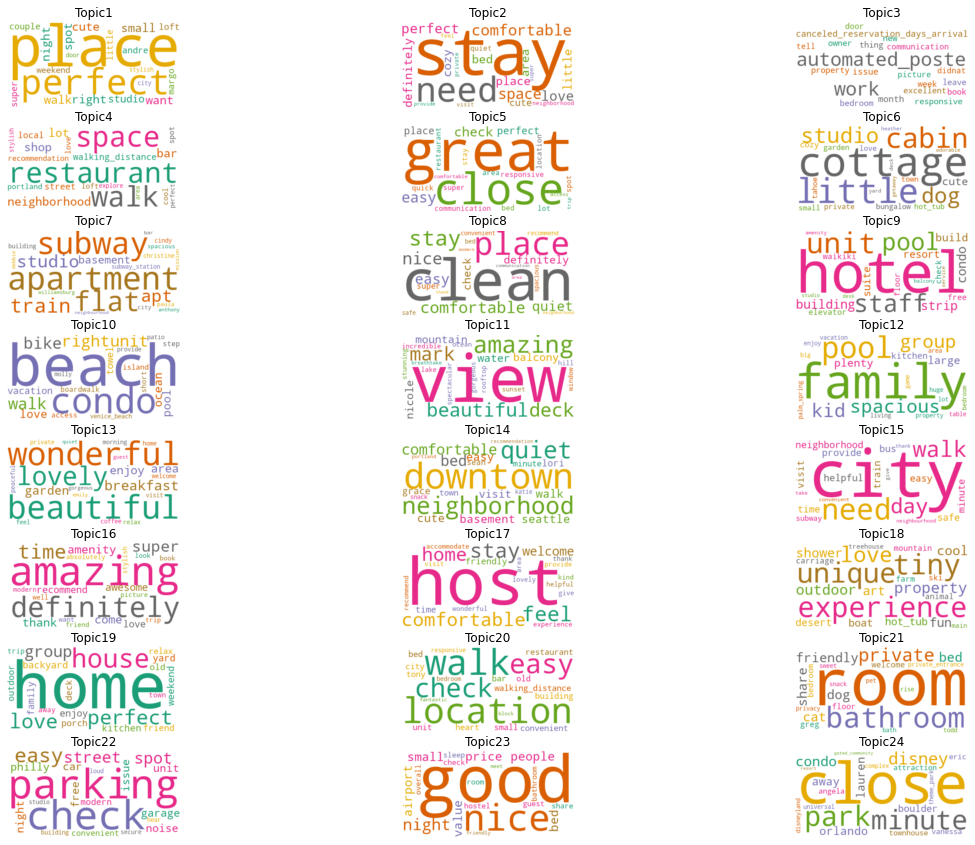

In [40]:
# Create Word Cloud of the topics for K = 24

from wordcloud import WordCloud

topics = [ [ (term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=20) ] for n in range(0, lda_model.num_topics) ]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], \
                         columns = ['Term'+str(i) for i in range(1, 21)], \
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)])

#pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms_in_Topic'], \
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

topics_df.head()


# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(24):

    wc.generate(text=topics_df['Terms_in_Topic'][i])
    
    plt.subplot(8, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [6]:
# Topic visualization for 28 topics
import pickle
lda_model = pickle.load(open('lda_model_28',"rb"))

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.119168  0.041977       1        1  14.795634
25     0.159379 -0.020982       2        1   5.886048
1      0.258889 -0.162166       3        1   5.585622
27     0.292588 -0.136720       4        1   4.857951
4      0.102629  0.133270       5        1   4.791489
16     0.085154 -0.239003       6        1   4.370893
18    -0.143057 -0.158959       7        1   4.132335
11    -0.161039  0.007367       8        1   3.739467
6     -0.040026  0.123176       9        1   3.689679
19     0.011537  0.242999      10        1   3.538040
20    -0.050273 -0.050320      11        1   3.453034
12    -0.121656 -0.256368      12        1   3.324548
22    -0.001312  0.088698      13        1   3.065643
0      0.005337  0.176516      14        1   2.977244
5     -0.098735 -0.105404      15        1   2.844886
3      0.001100  0.007866      16        1   2.785234
26     0.038420 -0.166139      17        1   2.758035
24     0.081582  0.063356      18        1   2.728261
13     0.119149  0.037553      19        1   2.582182
7      0.300508 -0.012320      20        1   2.532917
9     -0.136845  0.089928      21        1   2.309858
10    -0.194206 -0.070821      22        1   2.203234
14     0.093192  0.160470      23        1   2.172121
21     0.024657  0.214323      24        1   2.034909
15    -0.140734 -0.107870      25        1   1.994284
23    -0.062758  0.088402      26        1   1.657398
8     -0.139192  0.138318      27        1   1.625023
17    -0.165121 -0.127147      28        1   1.564032, topic_info=           Term          Freq         Total Category  logprob  loglift
348       place  2.104946e+06  2.104946e+06  Default  30.0000  30.0000
217       great  1.583459e+06  1.583459e+06  Default  29.0000  29.0000
451        stay  2.072029e+06  2.072029e+06  Default  28.0000  28.0000
26    apartment  1.062187e+06  1.062187e+06  Default  27.0000  27.0000
282    location  1.042419e+06  1.042419e+06  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
121        cool  8.954894e+03  4.541644e+04  Topic28  -4.2857   2.5342
1090   mountain  7.915947e+03  3.517869e+04  Topic28  -4.4090   2.6663
575     getaway  5.344505e+03  2.370411e+04  Topic28  -4.8018   2.6683
609    peaceful  4.534306e+03  3.774164e+04  Topic28  -4.9662   2.0388
1996        dog  4.382797e+03  1.300729e+05  Topic28  -5.0002   0.7675

[1942 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
163058      7  1.000717     abagail
52145       8  1.001491         abi
52670       7  1.001210     abigail
1           1  0.144642  absolutely
1           2  0.000885  absolutely
...       ...       ...         ...
18787      17  0.008355      yvette
18787      21  0.002785      yvette
16945      16  1.000059      yvonne
72899      16  1.002301     yvonnea
31854      26  1.000099        zach

[5492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 26, 2, 28, 5, 17, 19, 12, 7, 20, 21, 13, 23, 1, 6, 4, 27, 25, 14, 8, 10, 11, 15, 22, 16, 24, 9, 18])

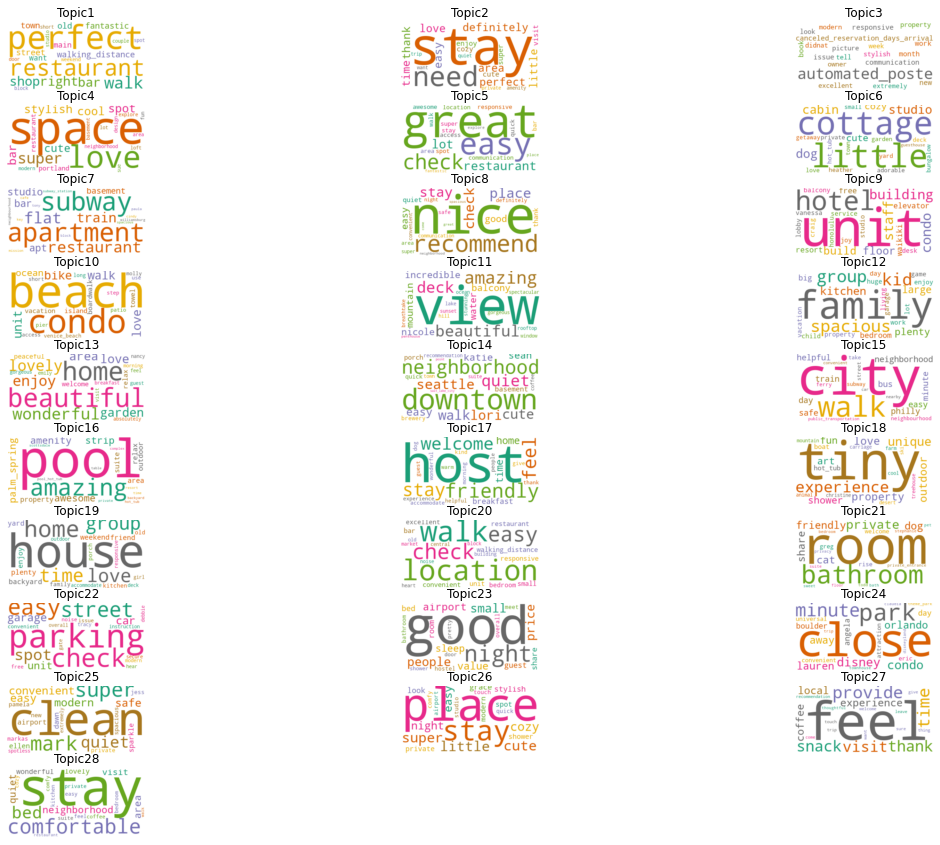

In [10]:
# Create Word Cloud of the topics for K = 28

from wordcloud import WordCloud

topics = [ [ (term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=20) ] for n in range(0, lda_model.num_topics) ]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], \
                         columns = ['Term'+str(i) for i in range(1, 21)], \
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)])

#pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms_in_Topic'], \
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

topics_df.head()


# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(lda_model.num_topics):

    wc.generate(text=topics_df['Terms_in_Topic'][i])
    
    plt.subplot(10, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [11]:
# Coherence for K = 28
from gensim.models import CoherenceModel
coherence_model = CoherenceModel(model = lda_model, texts = processed_reviews, dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model.get_coherence()

In [16]:
#print(' Coherence Score: ', coherence_lda)
a = np.load('K_vs_Coherence.npy')
print(a)

a = np.append(a,np.array([[28,coherence_lda]]), axis=0)
print(a)

np.save('K_vs_Coherence_28.npy',a)

[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]]
[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]]


In [18]:
# LDA with 32 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle

num_of_topics = 32

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001)

pickle.dump(lda_model,open('lda_model_32',"wb"))

In [ ]:
# Topic visualization for 32 topics
import pickle
#lda_model = pickle.load(open('lda_model_32',"rb"))

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

vis

In [19]:
from gensim.models import CoherenceModel
coherence_model = CoherenceModel(model = lda_model, texts = processed_reviews, dictionary = id2word, coherence = 'c_v')
coherence_lda = coherence_model.get_coherence()
print(' Coherence Score: ', coherence_lda)

 Coherence Score:  0.34530858694203714


In [20]:
#print(' Coherence Score: ', coherence_lda)
a = np.load('K_vs_Coherence_28.npy')
print(a)

a = np.append(a,np.array([[32,coherence_lda]]), axis=0)
print(a)

np.save('K_vs_Coherence_32.npy',a)

[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]]
[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [32.          0.34530859]]


In [ ]:
# LDA with 36 - 52 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle
import time

Num_Topics, Coherence_Score = [],[]


start_time = time.time()


for k in range(36, 56, 4):

    num_of_topics = k

    model_name = 'lda_model_' + str(num_of_topics)

    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001)

    pickle.dump(lda_model,open(model_name,"wb"))

    
    coherence_model = CoherenceModel(model = lda_model, texts = processed_reviews, dictionary = id2word, coherence = 'c_v')
    coherence_lda = coherence_model.get_coherence()
    
    print('Number of topic: ', num_of_topics,' Coherence Score: ', coherence_lda)
    
    #print('pickle.dump(lda_model,open(',model_name,',"wb"))')
    #coherence_lda = num_of_topics/10
    
    Num_Topics.append(num_of_topics)
    Coherence_Score.append(coherence_lda)
    
    
end_time = time.time()
print('Time Taken: ',end_time-start_time)

all_coherences = np.column_stack((Num_Topics,Coherence_Score))
np.save('K_vs_Coherence_36_52.npy',all_coherences)

C:\Users\s137c989\Anaconda3\lib\site-packages\gensim\topic_coherence\text_analysis.py:449: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("stats accumulation interrupted; <= %d documents processed", self._num_docs)


[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [32.          0.34530859]]


(0.0, 0.5)

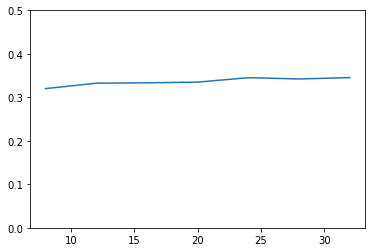

In [6]:
calculated_coherences = np.load('K_vs_Coherence_8_32.npy')
print(calculated_coherences)

plt.plot(calculated_coherences[:,0],calculated_coherences[:,1])
plt.ylim(0,0.5)

# It seems that Coherence Score is very stable across values of K. Hence, we select K = 15 below.

In [2]:
# Retrieve Pre-processed Dataset
Reviews_grouped = pd.read_pickle('Reviews_Mar20_Modified_Lemmatized.pkl.gz', compression='gzip')

# Create a list of list
processed_reviews = Reviews_grouped['review_comments'].tolist()

# Create Dictionary
id2word = corpora.Dictionary(processed_reviews)
print('Total Vocabulary Size:', len(id2word))

# Create Corpus : Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_reviews]

# Create Tf-Idf Model
tfidf = gensim.models.TfidfModel(corpus, id2word = id2word)


#filter words with low tf-idf

cut_off = 0.05

for i in range(0, len(corpus)):
    
    bow = corpus[i]
    bow_ids = [id for id, value in bow]
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < cut_off]
    
    #new_bow = [b for b in bow if b[0] not in low_value_words]
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] 

    #reassign        
    corpus[i] = new_bow

Total Vocabulary Size: 314664


In [7]:
# LDA with 15 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle


num_of_topics = 15

start_time = time.time()

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001,
                                           minimum_probability=0.0)

pickle.dump(lda_model,open('lda_model_15',"wb"))

coherence_model = CoherenceModel(model=lda_model, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('Coherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

Coherence Score:  0.3414757732800307


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.085200 -0.043116       1        1  17.060726
7     -0.278485  0.129195       2        1  11.030767
1     -0.188717  0.227945       3        1  10.809893
4     -0.273779 -0.065748       4        1   7.594807
11     0.235945  0.023105       5        1   6.821093
14    -0.111035  0.250216       6        1   6.695990
0     -0.143991 -0.285516       7        1   6.406219
12     0.189623  0.205671       8        1   5.526920
8      0.001699  0.010746       9        1   5.280567
6     -0.036631 -0.239078      10        1   4.737306
13    -0.097196 -0.078486      11        1   4.214598
3      0.116430  0.076386      12        1   3.932879
5      0.164193  0.030168      13        1   3.602568
9      0.077101 -0.215502      14        1   3.181397
10     0.259645 -0.025987      15        1   3.104265, topic_info=           Term          Freq         Total Category  logprob  loglift
217       great  1.582405e+06  1.582405e+06  Default  30.0000  30.0000
26    apartment  1.079199e+06  1.079199e+06  Default  29.0000  29.0000
348       place  2.078631e+06  2.078631e+06  Default  28.0000  28.0000
451        stay  2.080654e+06  2.080654e+06  Default  27.0000  27.0000
409        room  8.749390e+05  8.749390e+05  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
699       suite  5.915727e+03  3.826176e+04  Topic15  -5.3860   1.6056
588       hotel  6.374973e+03  5.397045e+04  Topic15  -5.3112   1.3363
1835      ocean  4.870750e+03  1.911285e+04  Topic15  -5.5804   2.1053
650      window  4.758188e+03  1.953439e+04  Topic15  -5.6038   2.0601
609    peaceful  4.848473e+03  3.779673e+04  Topic15  -5.5850   1.4188

[1162 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1          1  0.111390  absolutely
1          3  0.121071  absolutely
1          5  0.000053  absolutely
1          8  0.073921  absolutely
1         12  0.582676  absolutely
...      ...       ...         ...
3543       1  1.000125      youare
62144      8  1.000415        yumi
91454     10  1.000117         yve
16945     12  0.999797      yvonne
31854     10  0.999988        zach

[2999 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 2, 5, 12, 15, 1, 13, 9, 7, 14, 4, 6, 10, 11])

In [10]:
# Create the topic distribution for every document

mixture = [dict(lda_model[x]) for x in corpus]

Topic_Distribution_df = pd.DataFrame(mixture)
Topic_Distribution_df['listing_id'] = Reviews_grouped['listing_id']

cols = Topic_Distribution_df.columns.tolist()
cols = cols[-1:] + cols[:-1]

Topic_Distribution_df = Topic_Distribution_df[cols]

# Create the word distribution for each topic

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 30)])

Word_Distribution_df = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'Probability'])

In [31]:
# Save Topic Distribution and Word Distribution
Topic_Distribution_df.to_csv('Review_Topic_Distribution_15.csv.gz', compression='gzip')
Word_Distribution_df.to_csv('Topic_Word_Distribution_15.csv')

# Creating Topic - Doc Distribution and Word - Topic Distribution for K = 30 

In [ ]:
# LDA with 30 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle


num_of_topics = 30

start_time = time.time()

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001,
                                           minimum_probability=0.0)

pickle.dump(lda_model,open('lda_model_30',"wb"))

coherence_model = CoherenceModel(model=lda_model, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('Coherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [3]:
# Topic visualization for 30 topics
import pickle
from gensim.models import CoherenceModel
lda_model = pickle.load(open('lda_model_30',"rb"))

coherence_model = CoherenceModel(model=lda_model, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('Coherence Score: ', coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

vis

Coherence Score:  0.34620485693948855


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.128303  0.060625       1        1  10.599744
28     0.119245  0.176582       2        1   6.775998
11    -0.179308  0.119061       3        1   5.708779
1      0.286078 -0.087494       4        1   5.290272
27     0.328307 -0.098365       5        1   5.122428
4      0.076384  0.152180       6        1   4.893864
18    -0.084984 -0.119851       7        1   4.459156
12    -0.052476 -0.273626       8        1   3.986255
7      0.269112  0.111314       9        1   3.977359
25     0.051539 -0.051575      10        1   3.868755
19    -0.006616  0.225805      11        1   3.807462
6     -0.048871  0.061580      12        1   3.472129
26     0.100992 -0.119560      13        1   3.190760
24    -0.040892 -0.028886      14        1   3.187899
3      0.072022  0.078407      15        1   3.181051
16     0.098341 -0.202915      16        1   2.870332
22    -0.066041  0.129104      17        1   2.836438
13     0.127725  0.004934      18        1   2.412237
10    -0.172704 -0.116932      19        1   2.331705
8     -0.108224  0.208237      20        1   2.223200
5     -0.082323 -0.125268      21        1   2.222376
9     -0.103879  0.033028      22        1   2.068037
14     0.079538  0.155916      23        1   2.061059
15    -0.113214 -0.093949      24        1   1.854414
29    -0.070867 -0.086928      25        1   1.713863
23    -0.059120  0.074365      26        1   1.467555
0     -0.102861  0.091660      27        1   1.281206
17    -0.102299 -0.111814      28        1   1.191816
20     0.019809 -0.074634      29        1   1.142534
21    -0.106110 -0.091001      30        1   0.801312, topic_info=           Term          Freq         Total Category  logprob  loglift
348       place  2.093974e+06  2.093974e+06  Default  30.0000  30.0000
217       great  1.575704e+06  1.575704e+06  Default  29.0000  29.0000
451        stay  2.048829e+06  2.048829e+06  Default  28.0000  28.0000
26    apartment  1.069931e+06  1.069931e+06  Default  27.0000  27.0000
282    location  1.049027e+06  1.049027e+06  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2462     ground  3.571868e+03  7.127995e+03  Topic30  -4.5360   4.1357
1090   mountain  3.843504e+03  3.531093e+04  Topic30  -4.4627   2.6089
621     retreat  2.622149e+03  1.044683e+04  Topic30  -4.8450   3.4444
1563    seclude  2.278831e+03  8.804864e+03  Topic30  -4.9854   3.4750
1477     nature  2.056986e+03  6.401540e+03  Topic30  -5.0878   3.6914

[2063 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
163058      7  1.001086  abagail
171744     25  0.999750     abbi
0           1  0.464743     able
0           2  0.001391     able
0           3  0.084904     able
...       ...       ...      ...
18787       8  0.999069   yvette
16945      15  1.000124   yvonne
72899      15  1.000280  yvonnea
31854      26  0.999941     zach
129244      7  0.997165      zee

[5866 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 29, 12, 2, 28, 5, 19, 13, 8, 26, 20, 7, 27, 25, 4, 17, 23, 14, 11, 9, 6, 10, 15, 16, 30, 24, 1, 18, 21, 22])

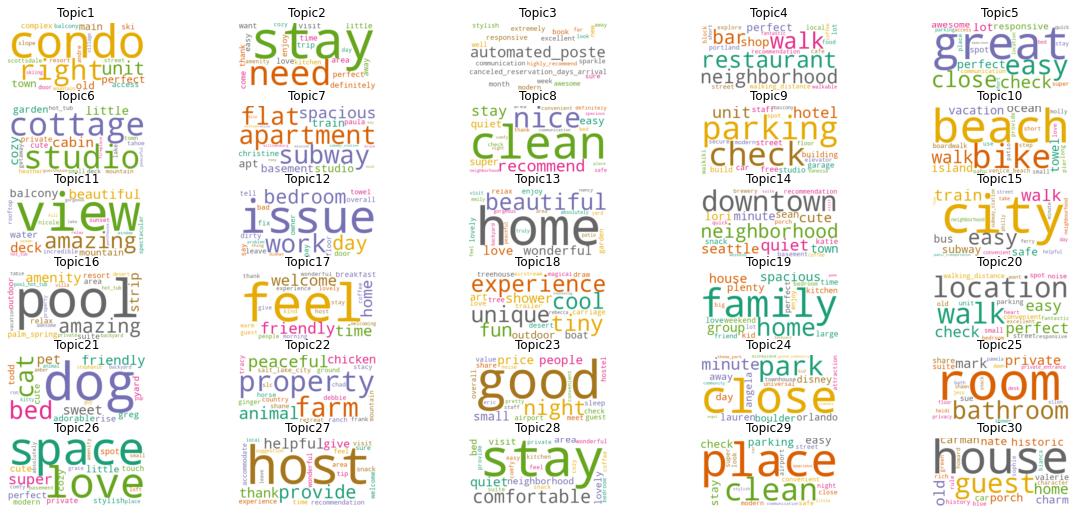

In [8]:
# Create Word Cloud of the topics for K = 30

from wordcloud import WordCloud

num_of_words = 20

topics = [ [ (term, round(wt, 3)) for term, wt in lda_model.show_topic(n, topn=num_of_words) ] for n in range(0, lda_model.num_topics) ]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], \
                         columns = ['Term'+str(i) for i in range(1, num_of_words+1)], \
                         index=['Topic '+str(t) for t in range(1, lda_model.num_topics+1)])

#pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms_in_Topic'], \
                         index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
topics_df

topics_df.head()


# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(lda_model.num_topics):

    wc.generate(text=topics_df['Terms_in_Topic'][i])
    
    plt.subplot(10, 5, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [10]:
# Create the topic distribution for every document

mixture = [dict(lda_model[x]) for x in corpus]

Topic_Distribution_df = pd.DataFrame(mixture)
Topic_Distribution_df['listing_id'] = Reviews_grouped['listing_id']

cols = Topic_Distribution_df.columns.tolist()
cols = cols[-1:] + cols[:-1]

Topic_Distribution_df = Topic_Distribution_df[cols]

# Create the word distribution for each topic

top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 30)])

Word_Distribution_df = pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'Probability'])

# Save Topic Distribution and Word Distribution
Topic_Distribution_df.to_csv('Review_Topic_Distribution_30.csv.gz', compression='gzip')
Word_Distribution_df.to_csv('Topic_Word_Distribution_30.csv')

In [12]:
# LDA with 42 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle


num_of_topics = 42

start_time = time.time()

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001,
                                           minimum_probability=0.0)

pickle.dump(lda_model,open('lda_model_42',"wb"))

coherence_model = CoherenceModel(model=lda_model, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3486139844080384


In [14]:
#print(' Coherence Score: ', coherence_lda)
a = np.load('K_vs_Coherence_8_50.npy')
print(a)

a = np.append(a,np.array([[42,coherence_lda]]), axis=0)
print(a)

np.save('K_vs_Coherence_8_50.npy',a)

[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [32.          0.34530859]
 [36.          0.34253352]
 [50.          0.35409677]
 [30.          0.34620486]
 [15.          0.34147577]]
[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [32.          0.34530859]
 [36.          0.34253352]
 [50.          0.35409677]
 [30.          0.34620486]
 [15.          0.34147577]
 [42.          0.34861398]]


In [18]:
a = np.load('K_vs_Coherence_8_50.npy')
print(a)

#an_array[numpy.argsort(an_array[:, 1])]

x = np.argsort(a[:, 0])

b = a[x]
print(b)

np.save('K_vs_Coherence_All.npy',b)

[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [32.          0.34530859]
 [36.          0.34253352]
 [50.          0.35409677]
 [30.          0.34620486]
 [15.          0.34147577]
 [42.          0.34861398]]
[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [15.          0.34147577]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [30.          0.34620486]
 [32.          0.34530859]
 [36.          0.34253352]
 [42.          0.34861398]
 [50.          0.35409677]]


[[ 8.          0.32002996]
 [12.          0.3324896 ]
 [15.          0.34147577]
 [16.          0.33340335]
 [20.          0.3349382 ]
 [24.          0.34517787]
 [28.          0.34226328]
 [30.          0.34620486]
 [32.          0.34530859]
 [36.          0.34253352]
 [42.          0.34861398]
 [50.          0.35409677]]


(0.0, 1.0)

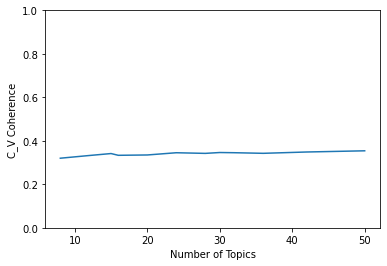

In [23]:
calculated_coherences = np.load('K_vs_Coherence_All.npy')
print(calculated_coherences)

plt.rcParams['figure.figsize'] = [6, 4]
plt.plot(calculated_coherences[:,0],calculated_coherences[:,1])
plt.xlabel('Number of Topics')
plt.ylabel('C_V Coherence')
plt.ylim(0,1)